In [1]:
import json
import pandas as pd
from tqdm.auto import tqdm
from sentence_transformers import SentenceTransformer
from elasticsearch import Elasticsearch
import groq

# Loading Actual Data

In [2]:
import json

# Update the file path to the JSON file
file_path = "/workspaces/Rag_Project_Pod/Data_prep/final_data.json"

# Load the JSON file into a dictionary
with open(file_path, 'r') as json_file:
    documents = json.load(json_file)

documents[0]


{'Category': 'General Information',
 'Question': 'What is syndicated research?',
 'Answer': 'Syndicated research is a type of market research where data and findings are collected and compiled by a research agency and then sold to multiple clients. It provides insights into consumer behavior, market trends, and product performance across various FMCG categories.',
 'doc_id': '3e72e1c8'}

# Loading Ground Truth Data

In [3]:
import pandas as pd

df_ground_truth = pd.read_csv(r'/workspaces/Rag_Project_Pod/Data_prep/ground_truth_data.csv')
df_ground_truth.head()                              

,Question,Category,Document
0,Can you explain what syndicated research entails?,General Information,3e72e1c8
1,What type of data is included in syndicated re...,General Information,3e72e1c8
2,Who compiles the findings for syndicated resea...,General Information,3e72e1c8
3,In what industries is syndicated research comm...,General Information,3e72e1c8
4,How can syndicated research benefit multiple c...,General Information,3e72e1c8


In [4]:
ground_truth = df_ground_truth.to_dict(orient='records')
ground_truth[0]

{'Question': 'Can you explain what syndicated research entails?',
 'Category': 'General Information',
 'Document': '3e72e1c8'}

In [5]:
doc_idx = {d['doc_id']: d for d in documents}

In [6]:
doc_idx['3e72e1c8']['Answer']

'Syndicated research is a type of market research where data and findings are collected and compiled by a research agency and then sold to multiple clients. It provides insights into consumer behavior, market trends, and product performance across various FMCG categories.'

# Index data


In [7]:
from sentence_transformers import SentenceTransformer


model_name = 'multi-qa-MiniLM-L6-cos-v1'
model = SentenceTransformer(model_name)

/home/codespace/.python/current/lib/python3.10/site-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


In [8]:
from elasticsearch import Elasticsearch

es_client = Elasticsearch('http://localhost:9200') 

index_settings = {
    "settings": {
        "number_of_shards": 1,
        "number_of_replicas": 0
    },
    "mappings": {
        "properties": {
            "Answer": {"type": "text"},
            "Category": {"type": "text"},
            "Question": {"type": "text"},
            "doc_id": {"type": "keyword"},
            "question_vector": {
                "type": "dense_vector",
                "dims": 384,
                "index": True,
                "similarity": "cosine"
            },
            "text_vector": {
                "type": "dense_vector",
                "dims": 384,
                "index": True,
                "similarity": "cosine"
            },
            "question_text_vector": {
                "type": "dense_vector",
                "dims": 384,
                "index": True,
                "similarity": "cosine"
            },
        }
    }
}

index_name = "insights-questions"

es_client.indices.delete(index=index_name, ignore_unavailable=True)
es_client.indices.create(index=index_name, body=index_settings)

ObjectApiResponse({'acknowledged': True, 'shards_acknowledged': True, 'index': 'insights-questions'})

In [9]:
for doc in tqdm(documents):
    question = doc['Question']
    text = doc['Answer']
    qt = question + ' ' + text

    doc['question_vector'] = model.encode(question)
    doc['text_vector'] = model.encode(text)
    doc['question_text_vector'] = model.encode(qt)

  0%|          | 0/260 [00:00<?, ?it/s]

In [10]:
for doc in tqdm(documents):
    es_client.index(index=index_name, document=doc)

  0%|          | 0/260 [00:00<?, ?it/s]

# Retrieval using Hybrid Search & RRF

In [11]:
def compute_rrf(rank, k=60):
    """ Our own implementation of the relevance score """
    return 1 / (k + rank)

In [12]:
def elastic_search_hybrid_rrf(field, query, vector, k=60):
    # KNN Query
    knn_query = {
        "field": field,
        "query_vector": vector,
        "k": 10,
        "num_candidates": 10000,
        "boost": 0.5
    }

    # Keyword Query
    keyword_query = {
        "bool": {
            "must": {
                "multi_match": {
                    "query": query,
                    "fields": ["Question", "Answer", "Category"],  # Updated fields
                    "type": "best_fields",
                    "boost": 0.5
                }
            }
        }
    }

    # KNN Search
    knn_results = es_client.search(
        index=index_name, 
        body={
            "knn": knn_query, 
            "size": 10
        }
    )['hits']['hits']
    
    # Keyword Search
    keyword_results = es_client.search(
        index=index_name, 
        body={
            "query": keyword_query, 
            "size": 10
        }
    )['hits']['hits']
    
    # Reciprocal Rank Fusion (RRF) scoring
    rrf_scores = {}
    
    # Calculate RRF scores for KNN results
    for rank, hit in enumerate(knn_results):
        doc_id = hit['_id']
        rrf_scores[doc_id] = compute_rrf(rank + 1, k)

    # Calculate RRF scores for keyword results
    for rank, hit in enumerate(keyword_results):
        doc_id = hit['_id']
        if doc_id in rrf_scores:
            rrf_scores[doc_id] += compute_rrf(rank + 1, k)
        else:
            rrf_scores[doc_id] = compute_rrf(rank + 1, k)

    # Sort RRF scores in descending order
    reranked_docs = sorted(rrf_scores.items(), key=lambda x: x[1], reverse=True)
    
    # Get top-K documents by the score
    final_results = []
    for doc_id, score in reranked_docs[:5]:
        doc = es_client.get(index=index_name, id=doc_id)
        final_results.append(doc['_source'])
    
    return final_results


In [18]:
def question_text_hybrid_rrf(q):
    question = q['Question']

    v_q = model.encode(question)

    return elastic_search_hybrid_rrf('question_text_vector', question, v_q)

In [19]:
query = {'Question': "What is the sample size?"}
search_results = question_text_hybrid_rrf(query)
search_results[0]['Answer']

'The consumer panel consists of approximately 10,000 households, representing diverse demographic and geographic segments to ensure the data is reflective of the broader population.'

# The RAG flow


In [15]:
def build_prompt(query, search_results):
    prompt_template = """
You're a syndicated market research provider. Answer the QUESTION based on the CONTEXT from the FAQ database.
Use only the facts from the CONTEXT when answering the QUESTION.

QUESTION: {question}

CONTEXT: 
{context}
""".strip()

    context = ""
    
    for doc in search_results:
        context = context + f"section: {doc['Category']}\nquestion: {doc['Question']}\nanswer: {doc['Answer']}\n\n"
    
    prompt = prompt_template.format(question=query, context=context).strip()
    return prompt

In [16]:
prompt = build_prompt(query['Question'], search_results)
prompt

"You're a syndicated market research provider. Answer the QUESTION based on the CONTEXT from the FAQ database.\nUse only the facts from the CONTEXT when answering the QUESTION.\n\nQUESTION: What is the sample size?\n\nCONTEXT: \nsection: Data Collection Methodology\nquestion: What is the sample size of the consumer panel?\nanswer: The consumer panel consists of approximately 10,000 households, representing diverse demographic and geographic segments to ensure the data is reflective of the broader population.\n\nsection: General Information\nquestion: What is the sample size for global studies?\nanswer: For global studies, the sample size typically includes over 50,000 respondents, ensuring a representative sample across different regions and demographics.\n\nsection: Data Collection Methodology\nquestion: How is household size factored into the research?\nanswer: Household size is factored into the research by segmenting data to understand how family size influences purchase behavior, 

In [20]:

import os
from openai import OpenAI

os.environ['OPENAI_API_KEY'] = 'enter key'
client = OpenAI()


def llm(prompt, model='gpt-4o-mini'):
    response = client.chat.completions.create(
        model=model,
        messages=[{"role": "user", "content": prompt}]
    )
    
    return response.choices[0].message.content

In [21]:
import os
from groq import Groq



# Initialize the Groq client using the API key
client_groq = Groq(api_key='add your key')

# Define the function to use Groq's LLM
def llm_groq(prompt, model='llama3-70b-8192'):  # Adjust the model name if needed
    response = client_groq.chat.completions.create(
        model=model,
        messages=[{"role": "user", "content": prompt}]
    )
    
    return response.choices[0].message.content

# Example usage:
result = llm_groq("Explain the importance of fast language models")
print(result)


Fast language models are a crucial component in various natural language processing (NLP) applications, and their importance cannot be overstated. Here are some reasons why:

1. **Real-time interactions**: Fast language models enable real-time interactions between humans and machines, which is essential for applications like chatbots, virtual assistants, and language translation systems. These models can respond quickly to user input, providing a seamless experience.
2. **Low latency**: Fast models reduce the latency between input and response, making them suitable for applications that require instant feedback, such as speech recognition, sentiment analysis, and text summarization.
3. **Improved user experience**: Fast language models can process and respond to user input quickly, leading to higher user satisfaction and engagement. This is particularly important in applications like customer service, where swift responses can resolve issues efficiently.
4. **Scalability**: Fast langua

In [21]:
def rag(query: dict, model='gpt-4o-mini') -> str:
    search_results = question_text_hybrid_rrf(query)
    prompt = build_prompt(query['Question'], search_results)
    answer = llm(prompt, model=model)
    return answer

In [20]:
ground_truth[6]

{'Question': 'Are quarterly summaries included with the monthly updates?',
 'Category': 'General Information',
 'Document': '7a6f8a30'}

In [21]:
rag(ground_truth[6])

'Yes, quarterly summaries are available as part of the data updates, which are typically done on a monthly basis.'

In [22]:
doc_idx['7a6f8a30']['Answer']

'The data is typically updated on a monthly basis, with quarterly and annual summaries available. Real-time or weekly updates may also be available depending on the subscription level.'

In [25]:
def rag_groq(query: dict, model='llama3-70b-8192') -> str:
    search_results = question_text_hybrid_rrf(query)
    prompt = build_prompt(query['Question'], search_results)
    answer = llm_groq(prompt, model=model)
    return answer

In [26]:
rag_groq(ground_truth[6])

'Based on the provided CONTEXT, the answer to the QUESTION is:\n\nNo, quarterly summaries are not included with the monthly updates. According to the CONTEXT, quarterly summaries are available, but they are not explicitly mentioned as being included with the monthly updates. The monthly updates are provided on a regular basis, and quarterly summaries are offered as an additional option.'

# LLM as a judge


* Evaluates responses of various LLM's using LLM(gpt 4o mini)

### Eval using AQA only ---checking relevance of LLM Answer against the question & original answer

In [22]:
prompt1_template = """
You are an expert evaluator for a Retrieval-Augmented Generation (RAG) system.
Your task is to analyze the relevance of the generated answer compared to the original answer provided.
Based on the relevance and similarity of the generated answer to the original answer, you will classify
it as "NON_RELEVANT", "PARTLY_RELEVANT", or "RELEVANT".

Here is the data for evaluation:

Original Answer: {answer_orig}
Generated Question: {question}
Generated Answer: {answer_llm}

Please analyze the content and context of the generated answer in relation to the original
answer and provide your evaluation in parsable JSON without using code blocks:

{{
  "Relevance": "NON_RELEVANT" | "PARTLY_RELEVANT" | "RELEVANT",
  "Explanation": "[Provide a brief explanation for your evaluation]"
}}
""".strip()



### Eval gpt 4o responses

In [24]:
#Load Dataframe to judge

import pandas as pd

# Load the CSV data from the given path
file_path = '/workspaces/Rag_Project_Pod/Evaluation/LLM Evaluation/llm_data/results-gpt4o-cosine.csv'
df_gpt4o = pd.read_csv(file_path)

# Display the first few rows of the data
df_gpt4o.head()



,answer_llm,answer_orig,document,question,category,cosine
0,Syndicated research is a type of market resear...,Syndicated research is a type of market resear...,3e72e1c8,Can you explain what syndicated research entails?,General Information,0.998721
1,Syndicated research includes data and findings...,Syndicated research is a type of market resear...,3e72e1c8,What type of data is included in syndicated re...,General Information,0.786594
2,The findings for syndicated research are compi...,Syndicated research is a type of market resear...,3e72e1c8,Who compiles the findings for syndicated resea...,General Information,0.792197
3,Syndicated research is commonly used in indust...,Syndicated research is a type of market resear...,3e72e1c8,In what industries is syndicated research comm...,General Information,0.834927
4,Syndicated research benefits multiple clients ...,Syndicated research is a type of market resear...,3e72e1c8,How can syndicated research benefit multiple c...,General Information,0.801818


In [25]:
samples = df_gpt4o.to_dict(orient='records')
record = samples[0]
record

{'answer_llm': 'Syndicated research is a type of market research where data and findings are collected and compiled by a research agency and then sold to multiple clients. It provides insights into consumer behavior, market trends, and product performance across various FMCG (Fast-Moving Consumer Goods) categories.',
 'answer_orig': 'Syndicated research is a type of market research where data and findings are collected and compiled by a research agency and then sold to multiple clients. It provides insights into consumer behavior, market trends, and product performance across various FMCG categories.',
 'document': '3e72e1c8',
 'question': 'Can you explain what syndicated research entails?',
 'category': 'General Information',
 'cosine': 0.9987208}

In [26]:
prompt = prompt1_template.format(**record)
print(prompt)

You are an expert evaluator for a Retrieval-Augmented Generation (RAG) system.
Your task is to analyze the relevance of the generated answer compared to the original answer provided.
Based on the relevance and similarity of the generated answer to the original answer, you will classify
it as "NON_RELEVANT", "PARTLY_RELEVANT", or "RELEVANT".

Here is the data for evaluation:

Original Answer: Syndicated research is a type of market research where data and findings are collected and compiled by a research agency and then sold to multiple clients. It provides insights into consumer behavior, market trends, and product performance across various FMCG categories.
Generated Question: Can you explain what syndicated research entails?
Generated Answer: Syndicated research is a type of market research where data and findings are collected and compiled by a research agency and then sold to multiple clients. It provides insights into consumer behavior, market trends, and product performance acros

In [27]:
answer = llm(prompt, model='gpt-4o-mini')

In [28]:
answer

'{\n  "Relevance": "RELEVANT",\n  "Explanation": "The generated answer is identical to the original answer, providing a full and accurate explanation of what syndicated research is. It addresses the question directly and thoroughly."\n}'

In [29]:
import json

evaluations = []

for record in tqdm(samples):
    prompt = prompt1_template.format(**record)
    evaluation = llm(prompt, model='gpt-4o-mini')
    evaluations.append(evaluation)

  0%|          | 0/1300 [00:00<?, ?it/s]

json_evaluations = []

for i, str_eval in enumerate(evaluations):
    json_eval = json.loads(str_eval)
    json_evaluations.append(json_eval)

In [33]:
import json
import re

json_evaluations = []

for i, str_eval in enumerate(evaluations):
    try:
        # Remove trailing commas before closing braces or brackets
        str_eval = re.sub(r',\s*([\]}])', r'\1', str_eval)
        json_eval = json.loads(str_eval)
        json_evaluations.append(json_eval)
    except json.JSONDecodeError as e:
        print(f"Error decoding JSON at index {i}: {e}")
        print(f"Problematic string: {str_eval}")


In [34]:
df_evaluations = pd.DataFrame(json_evaluations)
df_evaluations.Relevance.value_counts()


Relevance
RELEVANT           1059
PARTLY_RELEVANT     237
NON_RELEVANT          4
Name: count, dtype: int64

In [36]:
df_evaluations[df_evaluations.Relevance == 'NON_RELEVANT'] #.to_dict(orient='records')


,Relevance,Explanation
93,NON_RELEVANT,The generated answer fails to address the ques...
234,NON_RELEVANT,The generated answer addresses how frequently ...
644,NON_RELEVANT,The generated answer addresses a different que...
983,NON_RELEVANT,The generated answer does not address the core...


In [35]:
df_evaluations.to_csv('/workspaces/Rag_Project_Pod/Evaluation/LLM Evaluation/llm_data/evaluations-gpt4o-aqa.csv', index=False)


### Eval gpt 3.5 responses

In [28]:
#Load Dataframe to judge

import pandas as pd

# Load the CSV data from the given path
file_path = '/workspaces/Rag_Project_Pod/Evaluation/LLM Evaluation/llm_data/results-gpt35-cosine.csv'
df_gpt35 = pd.read_csv(file_path)

# Display the first few rows of the data
df_gpt35.head()



,answer_llm,answer_orig,document,question,category,cosine
0,Syndicated research entails a type of market r...,Syndicated research is a type of market resear...,3e72e1c8,Can you explain what syndicated research entails?,General Information,0.980938
1,The type of data included in syndicated resear...,Syndicated research is a type of market resear...,3e72e1c8,What type of data is included in syndicated re...,General Information,0.716210
2,The findings for syndicated research are compi...,Syndicated research is a type of market resear...,3e72e1c8,Who compiles the findings for syndicated resea...,General Information,0.792197
3,Syndicated research is commonly used in indust...,Syndicated research is a type of market resear...,3e72e1c8,In what industries is syndicated research comm...,General Information,0.796671
4,Syndicated research can benefit multiple clien...,Syndicated research is a type of market resear...,3e72e1c8,How can syndicated research benefit multiple c...,General Information,0.836032


In [31]:
samples = df_gpt35.to_dict(orient='records')
record = samples[0]
print(record)

prompt = prompt1_template.format(**record)
print(prompt)


answer = llm(prompt, model='gpt-4o-mini')
print(answer)

{'answer_llm': 'Syndicated research entails a type of market research where data and findings are collected and compiled by a research agency and then sold to multiple clients. It provides insights into consumer behavior, market trends, and product performance across various FMCG categories.', 'answer_orig': 'Syndicated research is a type of market research where data and findings are collected and compiled by a research agency and then sold to multiple clients. It provides insights into consumer behavior, market trends, and product performance across various FMCG categories.', 'document': '3e72e1c8', 'question': 'Can you explain what syndicated research entails?', 'category': 'General Information', 'cosine': 0.9809381}
You are an expert evaluator for a Retrieval-Augmented Generation (RAG) system.
Your task is to analyze the relevance of the generated answer compared to the original answer provided.
Based on the relevance and similarity of the generated answer to the original answer, y

In [32]:
import json

evaluations_gpt35 = []

for record in tqdm(samples):
    prompt = prompt1_template.format(**record)
    evaluation = llm(prompt, model='gpt-4o-mini')
    evaluations_gpt35.append(evaluation)

  0%|          | 0/1300 [00:00<?, ?it/s]

In [33]:
import json
import re

json_evaluations_gpt35 = []

for i, str_eval in enumerate(evaluations_gpt35):
    try:
        # Remove trailing commas before closing braces or brackets
        str_eval = re.sub(r',\s*([\]}])', r'\1', str_eval)
        json_eval = json.loads(str_eval)
        json_evaluations_gpt35.append(json_eval)
    except json.JSONDecodeError as e:
        print(f"Error decoding JSON at index {i}: {e}")
        print(f"Problematic string: {str_eval}")


In [34]:
df_evaluations_gpt35 = pd.DataFrame(json_evaluations_gpt35)
df_evaluations_gpt35.Relevance.value_counts()


Relevance
RELEVANT           945
PARTLY_RELEVANT    332
NON_RELEVANT        23
Name: count, dtype: int64

In [35]:
df_evaluations_gpt35[df_evaluations_gpt35.Relevance == 'NON_RELEVANT'] #.to_dict(orient='records')


,Relevance,Explanation
32,NON_RELEVANT,The generated answer does not address the spec...
165,NON_RELEVANT,The generated answer does not directly address...
220,NON_RELEVANT,The generated answer does not address the spec...
231,NON_RELEVANT,The generated answer focuses on geolocation da...
234,NON_RELEVANT,The generated answer addresses the frequency o...
266,NON_RELEVANT,The generated answer discusses consumer behavi...
369,NON_RELEVANT,The generated answer does not relate directly ...
496,NON_RELEVANT,The generated answer focuses on tracking produ...
536,NON_RELEVANT,The generated answer does not address the spec...
573,NON_RELEVANT,The generated answer directly contradicts the ...


In [36]:
df_evaluations_gpt35.to_csv('/workspaces/Rag_Project_Pod/Evaluation/LLM Evaluation/llm_data/evaluations-gpt35-aqa.csv', index=False)


### Eval llama 8b responses

In [37]:
#Load Dataframe to judge

import pandas as pd

# Load the CSV data from the given path
file_path = '/workspaces/Rag_Project_Pod/Evaluation/LLM Evaluation/llm_data/results-llama8b-cosine.csv'
df_llama8b = pd.read_csv(file_path)

# Display the first few rows of the data
df_llama8b.head()



,answer_llm,answer_orig,document,question,category,cosine
0,"Based on the provided context, syndicated rese...",Syndicated research is a type of market resear...,3e72e1c8,Can you explain what syndicated research entails?,General Information,0.907631
1,"Based on the CONTEXT from the FAQ database, th...",Syndicated research is a type of market resear...,3e72e1c8,What type of data is included in syndicated re...,General Information,0.739555
2,"Based on the provided CONTEXT, the answer to t...",Syndicated research is a type of market resear...,3e72e1c8,Who compiles the findings for syndicated resea...,General Information,0.617875
3,"Based on the CONTEXT, syndicated market resear...",Syndicated research is a type of market resear...,3e72e1c8,In what industries is syndicated research comm...,General Information,0.807952
4,"Based on the CONTEXT, syndicated research can ...",Syndicated research is a type of market resear...,3e72e1c8,How can syndicated research benefit multiple c...,General Information,0.790096


In [38]:
samples = df_llama8b.to_dict(orient='records')
record = samples[0]
print(record)

prompt = prompt1_template.format(**record)
print(prompt)


answer = llm(prompt, model='gpt-4o-mini')
print(answer)

{'answer_llm': 'Based on the provided context, syndicated research entails a research agency collecting and compiling data and findings, which are then sold to multiple clients, providing insights into consumer behavior, market trends, and product performance across various FMCG categories. In contrast, custom research is tailored to the specific needs of one client, delivering specific answers to particular business questions.', 'answer_orig': 'Syndicated research is a type of market research where data and findings are collected and compiled by a research agency and then sold to multiple clients. It provides insights into consumer behavior, market trends, and product performance across various FMCG categories.', 'document': '3e72e1c8', 'question': 'Can you explain what syndicated research entails?', 'category': 'General Information', 'cosine': 0.9076309}
You are an expert evaluator for a Retrieval-Augmented Generation (RAG) system.
Your task is to analyze the relevance of the generat

In [39]:
import json

evaluations_llama8b = []

for record in tqdm(samples):
    prompt = prompt1_template.format(**record)
    evaluation = llm(prompt, model='gpt-4o-mini')
    evaluations_llama8b.append(evaluation)

  0%|          | 0/1300 [00:00<?, ?it/s]

In [40]:
import json
import re

json_evaluations_llama8b = []

for i, str_eval in enumerate(evaluations_llama8b):
    try:
        # Remove trailing commas before closing braces or brackets
        str_eval = re.sub(r',\s*([\]}])', r'\1', str_eval)
        json_eval = json.loads(str_eval)
        json_evaluations_llama8b.append(json_eval)
    except json.JSONDecodeError as e:
        print(f"Error decoding JSON at index {i}: {e}")
        print(f"Problematic string: {str_eval}")


In [41]:
df_evaluations_llama8b = pd.DataFrame(json_evaluations_llama8b)
df_evaluations_llama8b.Relevance.value_counts()


Relevance
RELEVANT           987
PARTLY_RELEVANT    305
NON_RELEVANT         8
Name: count, dtype: int64

In [42]:
df_evaluations_llama8b[df_evaluations_llama8b.Relevance == 'NON_RELEVANT'] #.to_dict(orient='records')


,Relevance,Explanation
93,NON_RELEVANT,The generated answer lists channels that are n...
234,NON_RELEVANT,The original answer discusses how brand loyalt...
266,NON_RELEVANT,The generated answer lists types of consumer i...
632,NON_RELEVANT,The generated answer does not address the ques...
816,NON_RELEVANT,The generated answer incorrectly states that a...
902,NON_RELEVANT,The generated answer does not address the quer...
904,NON_RELEVANT,The generated answer incorrectly states that r...
1299,NON_RELEVANT,The generated answer does not address the ques...


In [43]:
df_evaluations_llama8b.to_csv('/workspaces/Rag_Project_Pod/Evaluation/LLM Evaluation/llm_data/evaluations-llama8b-aqa.csv', index=False)

### Eval Llama 70b responses

In [23]:
#Load Dataframe to judge

import pandas as pd

# Load the CSV data from the given path
file_path = '/workspaces/Rag_Project_Pod/Evaluation/LLM Evaluation/llm_data/results-llama70b-cosine.csv'
df_llama70b = pd.read_csv(file_path)

# Display the first few rows of the data
df_llama70b.head()



,answer_llm,answer_orig,document,question,category,cosine
0,"Based on the context, syndicated research enta...",Syndicated research is a type of market resear...,3e72e1c8,Can you explain what syndicated research entails?,General Information,0.952520
1,"According to the context, syndicated research ...",Syndicated research is a type of market resear...,3e72e1c8,What type of data is included in syndicated re...,General Information,0.830384
2,"According to the provided context, the researc...",Syndicated research is a type of market resear...,3e72e1c8,Who compiles the findings for syndicated resea...,General Information,0.674782
3,"Based on the CONTEXT, syndicated research is c...",Syndicated research is a type of market resear...,3e72e1c8,In what industries is syndicated research comm...,General Information,0.805541
4,"According to the context, syndicated research ...",Syndicated research is a type of market resear...,3e72e1c8,How can syndicated research benefit multiple c...,General Information,0.839169


In [25]:
samples = df_llama70b.to_dict(orient='records')
record = samples[0]
print(record)

prompt = prompt1_template.format(**record)
print(prompt)


answer = llm(prompt, model='gpt-4o-mini')
print(answer)

{'answer_llm': 'Based on the context, syndicated research entails a type of market research where a research agency collects and compiles data and findings, which are then sold to multiple clients. This research provides broad insights into consumer behavior, market trends, and product performance across various Fast-Moving Consumer Goods (FMCG) categories.', 'answer_orig': 'Syndicated research is a type of market research where data and findings are collected and compiled by a research agency and then sold to multiple clients. It provides insights into consumer behavior, market trends, and product performance across various FMCG categories.', 'document': '3e72e1c8', 'question': 'Can you explain what syndicated research entails?', 'category': 'General Information', 'cosine': 0.95251954}
You are an expert evaluator for a Retrieval-Augmented Generation (RAG) system.
Your task is to analyze the relevance of the generated answer compared to the original answer provided.
Based on the releva

In [26]:
import json

evaluations_llama70b = []

for record in tqdm(samples):
    prompt = prompt1_template.format(**record)
    evaluation = llm(prompt, model='gpt-4o-mini')
    evaluations_llama70b.append(evaluation)

  0%|          | 0/1300 [00:00<?, ?it/s]

In [27]:
import json
import re

json_evaluations_llama70b = []

for i, str_eval in enumerate(evaluations_llama70b):
    try:
        # Remove trailing commas before closing braces or brackets
        str_eval = re.sub(r',\s*([\]}])', r'\1', str_eval)
        json_eval = json.loads(str_eval)
        json_evaluations_llama70b.append(json_eval)
    except json.JSONDecodeError as e:
        print(f"Error decoding JSON at index {i}: {e}")
        print(f"Problematic string: {str_eval}")


In [28]:
df_evaluations_llama70b = pd.DataFrame(json_evaluations_llama70b)
df_evaluations_llama70b.Relevance.value_counts()


Relevance
RELEVANT           987
PARTLY_RELEVANT    308
NON_RELEVANT         5
Name: count, dtype: int64

In [29]:
df_evaluations_llama70b[df_evaluations_llama70b.Relevance == 'NON_RELEVANT'] #.to_dict(orient='records')


,Relevance,Explanation
189,NON_RELEVANT,The generated answer does not address the role...
234,NON_RELEVANT,The generated answer discusses the frequency o...
247,NON_RELEVANT,The generated answer does not address the orig...
266,NON_RELEVANT,The generated answer significantly diverges fr...
961,NON_RELEVANT,The generated answer does not provide any usef...


In [31]:
df_evaluations_llama70b.to_csv('/workspaces/Rag_Project_Pod/Evaluation/LLM Evaluation/llm_data/evaluations-llama70b-aqa.csv', index=False)


# Eval using QA only --- checking relevance of Answer against the question

### Eval gpt 4o 

In [32]:
prompt2_template = """
You are an expert evaluator for a Retrieval-Augmented Generation (RAG) system.
Your task is to analyze the relevance of the generated answer to the given question.
Based on the relevance of the generated answer, you will classify it
as "NON_RELEVANT", "PARTLY_RELEVANT", or "RELEVANT".

Here is the data for evaluation:

Question: {question}
Generated Answer: {answer_llm}

Please analyze the content and context of the generated answer in relation to the question
and provide your evaluation in parsable JSON without using code blocks:

{{
  "Relevance": "NON_RELEVANT" | "PARTLY_RELEVANT" | "RELEVANT",
  "Explanation": "[Provide a brief explanation for your evaluation]"
}}
""".strip()

In [33]:
prompt = prompt2_template.format(**record)
print(prompt)

You are an expert evaluator for a Retrieval-Augmented Generation (RAG) system.
Your task is to analyze the relevance of the generated answer to the given question.
Based on the relevance of the generated answer, you will classify it
as "NON_RELEVANT", "PARTLY_RELEVANT", or "RELEVANT".

Here is the data for evaluation:

Question: Can I convert reports into PDF for easy distribution?
Generated Answer: Based on the context, the answer to your question is: Yes, you can convert reports into PDF for easy distribution. The FAQ sections mention that reports can be exported in PDF format, and it is possible to export reports as PDFs by selecting the export option in the portal's report viewer.

Please analyze the content and context of the generated answer in relation to the question
and provide your evaluation in parsable JSON without using code blocks:

{
  "Relevance": "NON_RELEVANT" | "PARTLY_RELEVANT" | "RELEVANT",
  "Explanation": "[Provide a brief explanation for your evaluation]"
}


In [39]:
evaluation = llm(prompt, model='gpt-4o-mini')
print(evaluation)

{
  "Relevance": "RELEVANT",
  "Explanation": "The generated answer directly addresses the question by confirming that reports can be converted into PDF for distribution and provides a method for doing so, specifically mentioning the export option in the portal's report viewer. This information is pertinent and useful for the user's request."
}


In [40]:
evaluations_2 = []

for record in tqdm(samples):
    prompt = prompt2_template.format(**record)
    evaluation = llm(prompt, model='gpt-4o-mini')
    evaluations_2.append(evaluation)

  0%|          | 0/1300 [00:00<?, ?it/s]

In [43]:
import json
import re

json_evaluations_2 = []

for i, str_eval in enumerate(evaluations_2):
    try:
        # Remove trailing commas before closing braces or brackets
        str_eval = re.sub(r',\s*([\]}])', r'\1', str_eval)
        json_eval = json.loads(str_eval)
        json_evaluations_2.append(json_eval)
    except json.JSONDecodeError as e:
        print(f"Error decoding JSON at index {i}: {e}")
        print(f"Problematic string: {str_eval}")


In [44]:
df_evaluations_2 = pd.DataFrame(json_evaluations_2)
df_evaluations_2.Relevance.value_counts()


Relevance
RELEVANT           1233
PARTLY_RELEVANT      64
NON_RELEVANT          3
Name: count, dtype: int64

In [45]:
df_evaluations_2.to_csv('/workspaces/Rag_Project_Pod/Evaluation/LLM Evaluation/llm_data/evaluations-gpt4o-qa.csv', index=False)


In [46]:
df_evaluations_2[df_evaluations_2.Relevance == 'NON_RELEVANT']


,Relevance,Explanation
93,NON_RELEVANT,The generated answer states that there is no s...
189,NON_RELEVANT,The generated answer states that the provided ...
983,NON_RELEVANT,The generated answer does not directly address...


In [35]:
import json
import re
import pandas as pd
from tqdm import tqdm

def evaluate_samples(samples, prompt_template, model='gpt-4o-mini', llm_func=None):
    """
    Evaluates a list of samples by formatting prompts, passing them through the LLM, and handling JSON decoding.
    
    Args:
    - samples (list of dicts): List of records to be processed.
    - prompt_template (str): Template string for formatting the prompt.
    - model (str): The LLM model to use (default is 'gpt-4o-mini').
    - llm_func (function): Function to call the LLM. Expected signature: llm(prompt, model).
    
    Returns:
    - DataFrame: DataFrame of JSON-decoded evaluations.
    """
    evaluations = []
    
    # Generate prompts and get LLM responses
    for record in tqdm(samples):
        prompt = prompt_template.format(**record)
        evaluation = llm_func(prompt, model=model)
        evaluations.append(evaluation)

    # Convert string responses to JSON, handling any formatting issues
    json_evaluations = []
    for i, str_eval in enumerate(evaluations):
        try:
            # Remove trailing commas before closing braces or brackets
            str_eval = re.sub(r',\s*([\]}])', r'\1', str_eval)
            json_eval = json.loads(str_eval)
            json_evaluations.append(json_eval)
        except json.JSONDecodeError as e:
            print(f"Error decoding JSON at index {i}: {e}")
            print(f"Problematic string: {str_eval}")

    # Convert the JSON evaluations into a DataFrame
    df_evaluations = pd.DataFrame(json_evaluations)
    return df_evaluations



### Eval gpt 35 

In [36]:
#Load Dataframe to judge

import pandas as pd

# Load the CSV data from the given path
file_path = '/workspaces/Rag_Project_Pod/Evaluation/LLM Evaluation/llm_data/results-gpt35-cosine.csv'
df_gpt35 = pd.read_csv(file_path)


samples = df_gpt35.to_dict(orient='records')
record = samples[0]
print(record)

prompt = prompt2_template.format(**record)
print(prompt)


evaluation = llm(prompt, model='gpt-4o-mini')
print(evaluation)



{'answer_llm': 'Syndicated research entails a type of market research where data and findings are collected and compiled by a research agency and then sold to multiple clients. It provides insights into consumer behavior, market trends, and product performance across various FMCG categories.', 'answer_orig': 'Syndicated research is a type of market research where data and findings are collected and compiled by a research agency and then sold to multiple clients. It provides insights into consumer behavior, market trends, and product performance across various FMCG categories.', 'document': '3e72e1c8', 'question': 'Can you explain what syndicated research entails?', 'category': 'General Information', 'cosine': 0.9809381}
You are an expert evaluator for a Retrieval-Augmented Generation (RAG) system.
Your task is to analyze the relevance of the generated answer to the given question.
Based on the relevance of the generated answer, you will classify it
as "NON_RELEVANT", "PARTLY_RELEVANT",

In [37]:
df_evaluations_gpt35_2 = evaluate_samples(samples, prompt_template=prompt2_template, model='gpt-4o-mini', llm_func=llm)


100%|██████████| 1300/1300 [27:13<00:00,  1.26s/it]


In [38]:
print(df_evaluations_gpt35_2.Relevance.value_counts())

df_evaluations_gpt35_2[df_evaluations_gpt35_2.Relevance == 'NON_RELEVANT']

Relevance
RELEVANT           1162
PARTLY_RELEVANT     134
NON_RELEVANT          4
Name: count, dtype: int64


,Relevance,Explanation
232,NON_RELEVANT,The generated answer does not address the ques...
536,NON_RELEVANT,The generated answer indicates that the FAQ da...
772,NON_RELEVANT,The generated answer incorrectly states 'No' a...
1254,NON_RELEVANT,The generated answer does not address the ques...


In [40]:
df_evaluations_gpt35_2.to_csv('/workspaces/Rag_Project_Pod/Evaluation/LLM Evaluation/llm_data/evaluations-gpt35-qa.csv', index=False)


### Eval llama 8b 

In [39]:
#Load Dataframe to judge

import pandas as pd

# Load the CSV data from the given path
file_path = '/workspaces/Rag_Project_Pod/Evaluation/LLM Evaluation/llm_data/results-llama8b-cosine.csv'
df_llama8b = pd.read_csv(file_path)


samples = df_llama8b.to_dict(orient='records')
record = samples[0]
print(record)

prompt = prompt2_template.format(**record)
print(prompt)


evaluation = llm(prompt, model='gpt-4o-mini')
print(evaluation)



{'answer_llm': 'Based on the provided context, syndicated research entails a research agency collecting and compiling data and findings, which are then sold to multiple clients, providing insights into consumer behavior, market trends, and product performance across various FMCG categories. In contrast, custom research is tailored to the specific needs of one client, delivering specific answers to particular business questions.', 'answer_orig': 'Syndicated research is a type of market research where data and findings are collected and compiled by a research agency and then sold to multiple clients. It provides insights into consumer behavior, market trends, and product performance across various FMCG categories.', 'document': '3e72e1c8', 'question': 'Can you explain what syndicated research entails?', 'category': 'General Information', 'cosine': 0.9076309}
You are an expert evaluator for a Retrieval-Augmented Generation (RAG) system.
Your task is to analyze the relevance of the generat

In [41]:
df_evaluations_llama8b_2 = evaluate_samples(samples, 
                                            prompt_template=prompt2_template, 
                                            model='gpt-4o-mini', 
                                            llm_func=llm)


100%|██████████| 1300/1300 [27:32<00:00,  1.27s/it] 


In [44]:
print(df_evaluations_llama8b_2.Relevance.value_counts())

df_evaluations_llama8b_2[df_evaluations_llama8b_2.Relevance == 'NON_RELEVANT']

Relevance
RELEVANT           1207
PARTLY_RELEVANT      92
NON_RELEVANT          1
Name: count, dtype: int64


,Relevance,Explanation
961,NON_RELEVANT,The generated answer does not directly address...


In [43]:
df_evaluations_llama8b_2.to_csv('/workspaces/Rag_Project_Pod/Evaluation/LLM Evaluation/llm_data/evaluations-llama8b-qa.csv', index=False)


### Eval llama 70b 

In [45]:
#Load Dataframe to judge

import pandas as pd

# Load the CSV data from the given path
file_path = '/workspaces/Rag_Project_Pod/Evaluation/LLM Evaluation/llm_data/results-llama70b-cosine.csv'
df_llama70b = pd.read_csv(file_path)


samples = df_llama70b.to_dict(orient='records')
record = samples[0]
print(record)

prompt = prompt2_template.format(**record)
print(prompt)


evaluation = llm(prompt, model='gpt-4o-mini')
print(evaluation)



{'answer_llm': 'Based on the context, syndicated research entails a type of market research where a research agency collects and compiles data and findings, which are then sold to multiple clients. This research provides broad insights into consumer behavior, market trends, and product performance across various Fast-Moving Consumer Goods (FMCG) categories.', 'answer_orig': 'Syndicated research is a type of market research where data and findings are collected and compiled by a research agency and then sold to multiple clients. It provides insights into consumer behavior, market trends, and product performance across various FMCG categories.', 'document': '3e72e1c8', 'question': 'Can you explain what syndicated research entails?', 'category': 'General Information', 'cosine': 0.95251954}
You are an expert evaluator for a Retrieval-Augmented Generation (RAG) system.
Your task is to analyze the relevance of the generated answer to the given question.
Based on the relevance of the generate

In [46]:
df_evaluations_llama70b_2 = evaluate_samples(samples, 
                                             prompt_template=prompt2_template, 
                                             model='gpt-4o-mini', 
                                             llm_func=llm)


100%|██████████| 1300/1300 [27:11<00:00,  1.26s/it] 


In [47]:
print(df_evaluations_llama70b_2.Relevance.value_counts())

df_evaluations_llama70b_2[df_evaluations_llama70b_2.Relevance == 'NON_RELEVANT']

Relevance
RELEVANT           1215
PARTLY_RELEVANT      81
NON_RELEVANT          4
Name: count, dtype: int64


,Relevance,Explanation
189,NON_RELEVANT,The generated answer does not address the ques...
236,NON_RELEVANT,The generated answer does not address the ques...
247,NON_RELEVANT,The generated answer does not address the ques...
961,NON_RELEVANT,The generated answer does not provide specific...


In [48]:
df_evaluations_llama70b_2.to_csv('/workspaces/Rag_Project_Pod/Evaluation/LLM Evaluation/llm_data/evaluations-llama70b-qa.csv', index=False)


# Summarising results

In [1]:
import pandas as pd

df_gpt4o_aqa = pd.read_csv('/workspaces/Rag_Project_Pod/Evaluation/LLM Evaluation/llm_data/evaluations-gpt4o-aqa.csv')
df_gpt4o_qa = pd.read_csv('/workspaces/Rag_Project_Pod/Evaluation/LLM Evaluation/llm_data/evaluations-gpt4o-qa.csv')

df_gpt35_aqa = pd.read_csv('/workspaces/Rag_Project_Pod/Evaluation/LLM Evaluation/llm_data/evaluations-gpt35-aqa.csv')
df_gpt35_qa = pd.read_csv('/workspaces/Rag_Project_Pod/Evaluation/LLM Evaluation/llm_data/evaluations-gpt35-qa.csv')


df_llama8b_aqa = pd.read_csv('/workspaces/Rag_Project_Pod/Evaluation/LLM Evaluation/llm_data/evaluations-llama8b-aqa.csv')
df_llama8b_qa = pd.read_csv('/workspaces/Rag_Project_Pod/Evaluation/LLM Evaluation/llm_data/evaluations-llama8b-qa.csv')

df_llama70b_aqa = pd.read_csv('/workspaces/Rag_Project_Pod/Evaluation/LLM Evaluation/llm_data/evaluations-llama70b-aqa.csv')
df_llama70b_qa = pd.read_csv('/workspaces/Rag_Project_Pod/Evaluation/LLM Evaluation/llm_data/evaluations-llama70b-qa.csv')



In [1]:
import pandas as pd

# Function to calculate relevance counts
def summarize_relevance(df, model_name):
    return df['Relevance'].value_counts().rename(model_name)

# AQA DataFrames
df_gpt4o_aqa = pd.read_csv('/workspaces/Rag_Project_Pod/Evaluation/LLM Evaluation/llm_data/evaluations-gpt4o-aqa.csv')
df_gpt35_aqa = pd.read_csv('/workspaces/Rag_Project_Pod/Evaluation/LLM Evaluation/llm_data/evaluations-gpt35-aqa.csv')
df_llama8b_aqa = pd.read_csv('/workspaces/Rag_Project_Pod/Evaluation/LLM Evaluation/llm_data/evaluations-llama8b-aqa.csv')
df_llama70b_aqa = pd.read_csv('/workspaces/Rag_Project_Pod/Evaluation/LLM Evaluation/llm_data/evaluations-llama70b-aqa.csv')

# QA DataFrames
df_gpt4o_qa = pd.read_csv('/workspaces/Rag_Project_Pod/Evaluation/LLM Evaluation/llm_data/evaluations-gpt4o-qa.csv')
df_gpt35_qa = pd.read_csv('/workspaces/Rag_Project_Pod/Evaluation/LLM Evaluation/llm_data/evaluations-gpt35-qa.csv')
df_llama8b_qa = pd.read_csv('/workspaces/Rag_Project_Pod/Evaluation/LLM Evaluation/llm_data/evaluations-llama8b-qa.csv')
df_llama70b_qa = pd.read_csv('/workspaces/Rag_Project_Pod/Evaluation/LLM Evaluation/llm_data/evaluations-llama70b-qa.csv')

# Summarize AQA relevance counts
aqa_summary = pd.concat([
    summarize_relevance(df_gpt4o_aqa, 'GPT4o AQA'),
    summarize_relevance(df_gpt35_aqa, 'GPT3.5 AQA'),
    summarize_relevance(df_llama8b_aqa, 'Llama-8b AQA'),
    summarize_relevance(df_llama70b_aqa, 'Llama-70b AQA')
], axis=1).fillna(0)

# Summarize QA relevance counts
qa_summary = pd.concat([
    summarize_relevance(df_gpt4o_qa, 'GPT4o QA'),
    summarize_relevance(df_gpt35_qa, 'GPT3.5 QA'),
    summarize_relevance(df_llama8b_qa, 'Llama-8b QA'),
    summarize_relevance(df_llama70b_qa, 'Llama-70b QA')
], axis=1).fillna(0)


# Calculate percentages for AQA summary
aqa_percentage = aqa_summary.div(aqa_summary.sum(axis=0), axis=1) * 100

# Calculate percentages for QA summary
qa_percentage = qa_summary.div(qa_summary.sum(axis=0), axis=1) * 100


In [2]:
aqa_summary, qa_summary

(                 GPT4o AQA  GPT3.5 AQA  Llama-8b AQA  Llama-70b AQA
 Relevance                                                          
 RELEVANT              1059         945           987            987
 PARTLY_RELEVANT        237         332           305            308
 NON_RELEVANT             4          23             8              5,
                  GPT4o QA  GPT3.5 QA  Llama-8b QA  Llama-70b QA
 Relevance                                                      
 RELEVANT             1233       1162         1207          1215
 PARTLY_RELEVANT        64        134           92            81
 NON_RELEVANT            3          4            1             4)

In [3]:
aqa_percentage,qa_percentage

(                 GPT4o AQA  GPT3.5 AQA  Llama-8b AQA  Llama-70b AQA
 Relevance                                                          
 RELEVANT         81.461538   72.692308     75.923077      75.923077
 PARTLY_RELEVANT  18.230769   25.538462     23.461538      23.692308
 NON_RELEVANT      0.307692    1.769231      0.615385       0.384615,
                   GPT4o QA  GPT3.5 QA  Llama-8b QA  Llama-70b QA
 Relevance                                                       
 RELEVANT         94.846154  89.384615    92.846154     93.461538
 PARTLY_RELEVANT   4.923077  10.307692     7.076923      6.230769
 NON_RELEVANT      0.230769   0.307692     0.076923      0.307692)

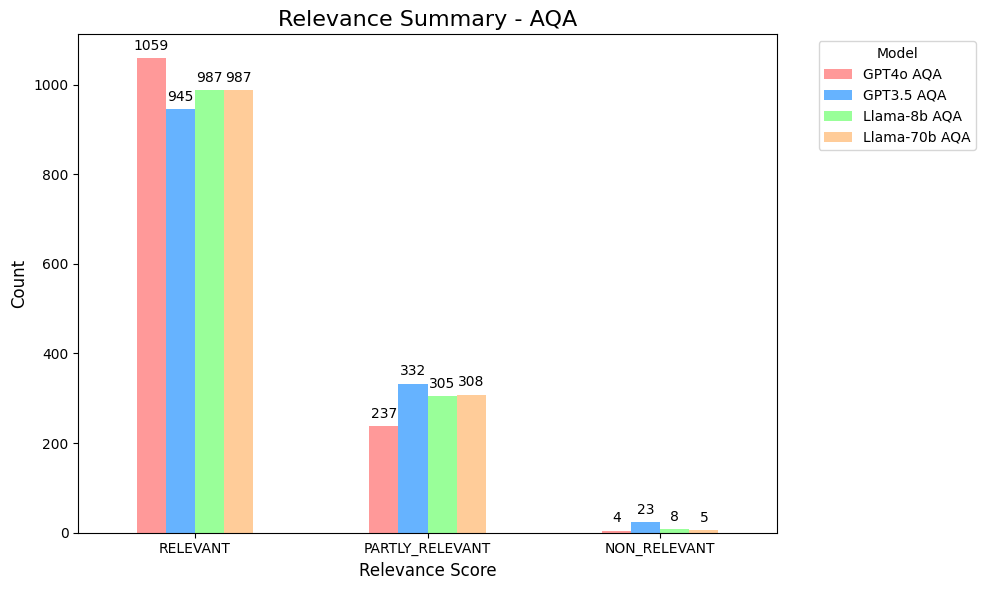

In [4]:
import pandas as pd
import matplotlib.pyplot as plt

# Function to add data labels to each bar
def add_data_labels(ax):
    for p in ax.patches:
        ax.annotate(f'{p.get_height():.0f}', 
                    (p.get_x() + p.get_width() / 2., p.get_height()), 
                    ha='center', va='center', 
                    xytext=(0, 9), 
                    textcoords='offset points',
                    fontsize=10)

# Light colors for the bar charts
colors = ['#ff9999','#66b3ff','#99ff99','#ffcc99']

# Bar chart for AQA summary
ax_aqa = aqa_summary.plot(kind='bar', figsize=(10, 6), color=colors)
plt.title('Relevance Summary - AQA', fontsize=16)
plt.ylabel('Count', fontsize=12)
plt.xlabel('Relevance Score', fontsize=12)
plt.xticks(rotation=0)
plt.legend(title='Model', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()

# Add data labels
add_data_labels(ax_aqa)

plt.show()



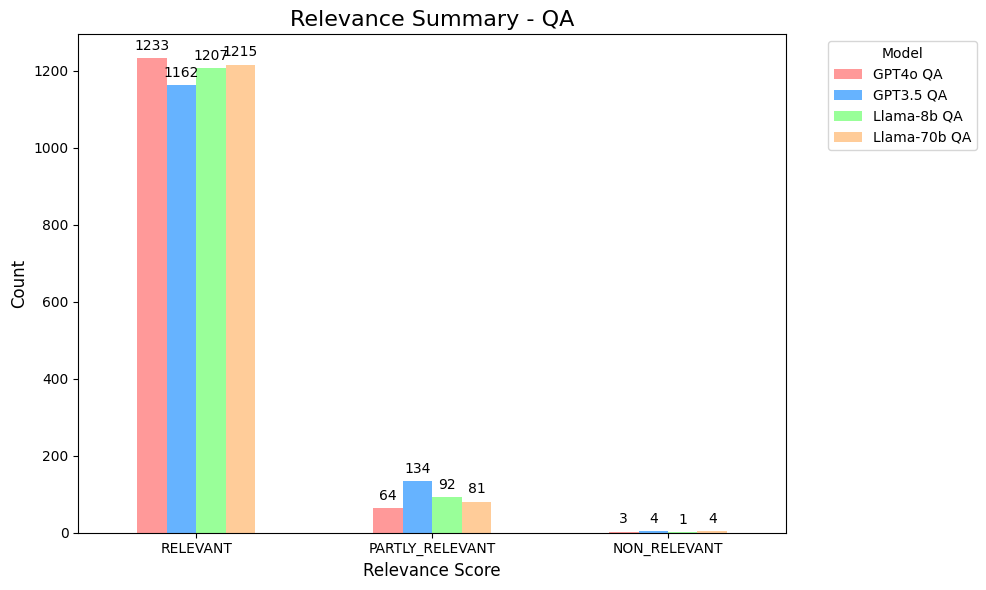

In [5]:
# Bar chart for QA summary
ax_qa = qa_summary.plot(kind='bar', figsize=(10, 6), color=colors)
plt.title('Relevance Summary - QA', fontsize=16)
plt.ylabel('Count', fontsize=12)
plt.xlabel('Relevance Score', fontsize=12)
plt.xticks(rotation=0)
plt.legend(title='Model', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()

# Add data labels
add_data_labels(ax_qa)

plt.show()


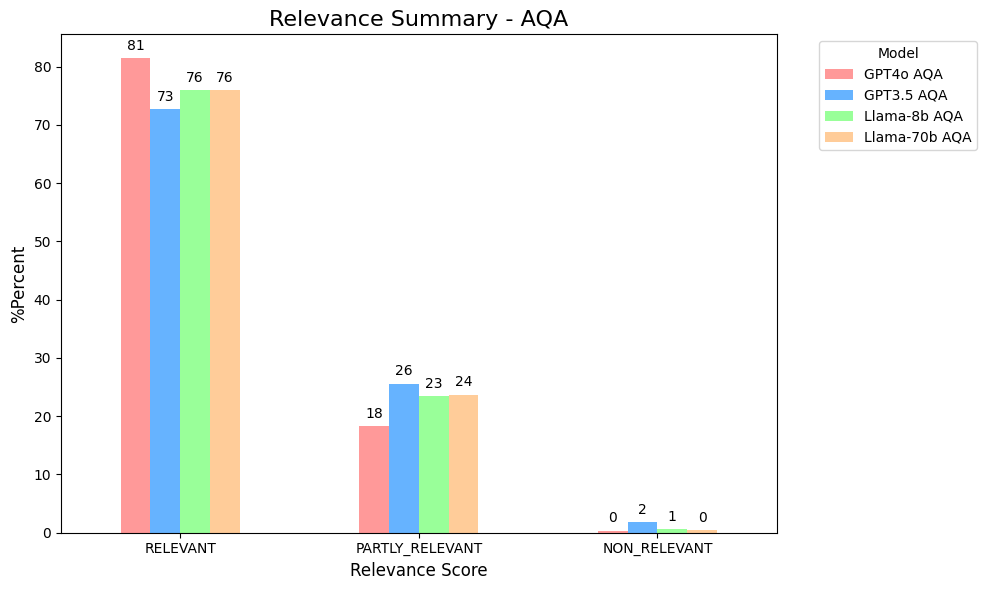

In [7]:
import pandas as pd
import matplotlib.pyplot as plt



# Bar chart for AQA summary
ax_aqa = aqa_percentage.plot(kind='bar', figsize=(10, 6), color=colors)
plt.title('Relevance Summary - AQA', fontsize=16)
plt.ylabel('%Percent', fontsize=12)
plt.xlabel('Relevance Score', fontsize=12)
plt.xticks(rotation=0)
plt.legend(title='Model', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()

# Add data labels
add_data_labels(ax_aqa)

plt.show()



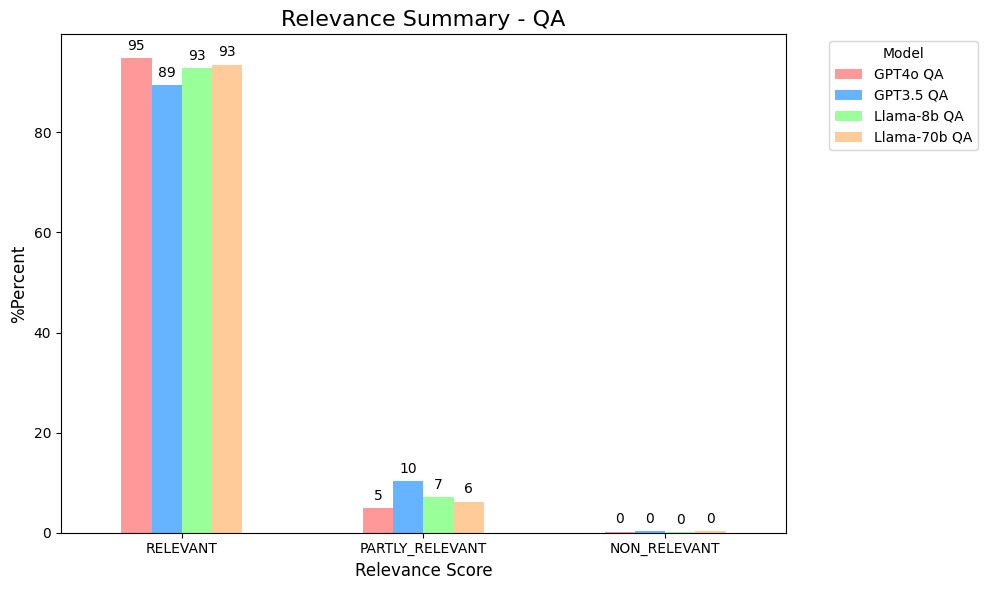

In [9]:
import pandas as pd
import matplotlib.pyplot as plt



# Bar chart for AQA summary
ax_aqa = qa_percentage.plot(kind='bar', figsize=(10, 6), color=colors)
plt.title('Relevance Summary - QA', fontsize=16)
plt.ylabel('%Percent', fontsize=12)
plt.xlabel('Relevance Score', fontsize=12)
plt.xticks(rotation=0)
plt.legend(title='Model', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()

# Add data labels
add_data_labels(ax_aqa)

plt.show()

